In [ ]:
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
import cv2
import pandas as pd
from google.colab import drive
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle as pkl
import shutil
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
import datetime
import tqdm
import yaml

% matplotlib inline
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip / content / drive / MyDrive / Baggage / positive-Annotation.zip

os.mkdir('dataset')
!unzip / content / drive / MyDrive / Baggage / positive_JPEGImage.zip -d / content / dataset

os.mkdir('dataset_negative')
!unzip / content / drive / MyDrive / Baggage / negative_JPEGImage.zip -d / content / dataset_negative

# –ì–ª–æ–±–∞–ª—å–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã

In [ ]:
CLASSES = ('Gun', 'Knife', 'Wrench', 'Pliers', 'Scissors')

PATH_POSITIVE_IMGS = '/content/dataset'
PATH_NEGATIVE_IMGS = '/content/dataset_negative'

# INCLUDE_NO_OBJECT_IMGS: False, –µ—Å–ª–∏ –Ω–µ –≤–∫–ª—é—á–∞—Ç—å –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è,
# –≤ –∏–Ω–æ–º —Å–ª—É—á–∞–µ - –∑–Ω–∞—á–µ–Ω–∏–µ –æ—Ç 0 –¥–æ 1 (–¥–æ–ª—è –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π, –≤—Å–µ–≥–æ –∏—Ö 10736 —à—Ç.)
INCLUDE_NO_OBJECT_IMGS = 0.2

# TEST_SIZE, VAL_SIZE: –∑–Ω–∞—á–µ–Ω–∏–µ –æ—Ç 0 –¥–æ 1 (–¥–æ–ª—è —Ç–µ—Å—Ç–æ–≤—ã—Ö –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã—Ö 
# –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π) –æ—Ç –æ–±—â–µ–≥–æ —á–∏—Å–ª–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏ –æ—Ç –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π, –Ω–µ –≤–∫–ª—é—á–∞—é—â–∏—Ö
# —Ç–µ—Å—Ç–æ–≤—ã–π –Ω–∞–±–æ—Ä —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ
TEST_SIZE = 0.3
VAL_SIZE = 0.25

# RESIZE_IMAGES (int/bool): False, –∏–ª–∏ —Ä–∞–∑–º–µ—Ä, –∫ –∫–æ—Ç–æ—Ä–æ–º—É –æ–±—Ä–µ–∂—É—Ç—Å—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è 
# (–æ–±—ã—á–Ω–æ - 640)
RESIZE_IMAGES = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# –ê–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö

## –ü–æ–ª—É—á–µ–Ω–∏–µ pandas DataFrame'–∞ –∏–∑ xml —Ñ–∞–π–ª–æ–≤

In [ ]:
images = os.listdir('dataset')
print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Å–µ—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {len(images)} —à—Ç.')

positive_images = []
negative_images = []
uncertain_files = []
for img in images:
    if img.startswith('P'):
        positive_images.append(img)
    elif img.startswith('N'):
        negative_images.append(img)
    else:
        uncertain_files.append(img)

print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {len(positive_images)} —à—Ç., \
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {len(negative_images)} —à—Ç., \
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Ñ–∞–π–ª–æ–≤: {len(uncertain_files)} —à—Ç.')

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Å–µ—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 8827 —à—Ç.
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 8827 —à—Ç., –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 0 —à—Ç., –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Ñ–∞–π–ª–æ–≤: 0 —à—Ç.


In [ ]:
def df_positive_images():
    no_object_xml_files = []
    no_size_xml_files = []
    wrong_object_xml_files = []
    size_mismatch = []
    info_all_imgs = []

    for img in positive_images:
        xml_path = f'/content/Annotation/{img[:-4]}.xml'
        tree = ET.parse(xml_path)
        root = tree.getroot()

        if root.find('size') is None:
            no_size_xml_files.append(img)
            img_path = f'/content/dataset/{img}'
            img = cv2.imread(img_path)
            height, width, depth = img.shape
        else:
            width = int(root.find('size').find('width').text)
            height = int(root.find('size').find('height').text)
            depth = int(root.find('size').find('depth').text)
            if (width != int(root.find('size').find('width').text) or
                    height != int(root.find('size').find('height').text) or
                    depth != int(root.find('size').find('depth').text)):
                size_mismatch.append(img)

        if root.findall('object') != []:
            for member in root.findall('object'):
                if member.find('bndbox') is None or member.find('name') is None:
                    wrong_object_xml_files.append(img)
                    continue
                obj = [img,
                       int(float(member.find('bndbox').find('xmin').text)),
                       int(float(member.find('bndbox').find('ymin').text)),
                       int(float(member.find('bndbox').find('xmax').text)),
                       int(float(member.find('bndbox').find('ymax').text)),
                       CLASSES.index(member.find('name').text),
                       member.find('name').text,
                       height, width, depth]
                info_all_imgs.append(obj)
        else:
            no_object_xml_files.append(img)

    positive_img_df = pd.DataFrame(
        columns=['images', 'xmin', 'ymin', 'xmax', 'ymax', 'class',
                 'name_class', 'width', 'height', 'depth'],
        data=info_all_imgs)

    return (positive_img_df, no_object_xml_files, no_size_xml_files,
            wrong_object_xml_files, size_mismatch)


(positive_img_df, no_object_xml_files, no_size_xml_files,
 wrong_object_xml_files, size_mismatch) = df_positive_images()
positive_img_df.head()

images  xmin  ymin  xmax  ymax  class name_class  width  height  depth
0  P06822.jpg   219   294   266   414      3     Pliers    455     474      3
1  P06822.jpg   180   260   250   359      3     Pliers    455     474      3
2  P06822.jpg    98   264   268   366      2     Wrench    455     474      3
3  P08330.jpg   163   340   275   440      3     Pliers    604     374      3
4  P03856.jpg   380   272   398   394      1      Knife    512     551      3

In [ ]:
positive_img_df.name_class.unique()

array(['Pliers', 'Wrench', 'Knife', 'Gun', 'Scissors'], dtype=object)

### –ü—Ä–æ–≤–µ—Ä–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [ ]:
print(f'–ö–∞—Ä—Ç–∏–Ω–∫–∏, –∫ –∫–æ—Ç–æ—Ä—ã–º –Ω–µ—Ç bounding boxes: {no_object_xml_files}.\n\
–ò—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(no_object_xml_files)} —à—Ç.')

print(f'–ö–∞—Ä—Ç–∏–Ω–∫–∏, –∫ –∫–æ—Ç–æ—Ä—ã–º –Ω–µ—Ç —Ä–∞–∑–º–µ—Ä–æ–≤: {no_size_xml_files}.\n\
–ò—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(no_size_xml_files)} —à—Ç.')

print(f'–ö–∞—Ä—Ç–∏–Ω–∫–∏, —É –∫–æ—Ç–æ—Ä—ã—Ö –µ—Å—Ç—å –ø—É—Å—Ç—ã–µ –ø–æ–ª—è object: {wrong_object_xml_files}.\n\
–ò—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(wrong_object_xml_files)} —à—Ç.')

–ö–∞—Ä—Ç–∏–Ω–∫–∏, –∫ –∫–æ—Ç–æ—Ä—ã–º –Ω–µ—Ç bounding boxes: ['P05111.jpg', 'P06239.jpg', 'P08009.jpg', 'P05537.jpg', 'P07217.jpg', 'P06733.jpg', 'P05538.jpg', 'P05535.jpg', 'P05536.jpg', 'P06846.jpg', 'P06732.jpg', 'P08008.jpg', 'P07219.jpg', 'P08010.jpg', 'P08341.jpg', 'P08007.jpg', 'P06240.jpg', 'P08342.jpg', 'P07218.jpg', 'P05110.jpg', 'P05592.jpg'].
–ò—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 21 —à—Ç.
–ö–∞—Ä—Ç–∏–Ω–∫–∏, –∫ –∫–æ—Ç–æ—Ä—ã–º –Ω–µ—Ç —Ä–∞–∑–º–µ—Ä–æ–≤: [].
–ò—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 0 —à—Ç.
–ö–∞—Ä—Ç–∏–Ω–∫–∏, —É –∫–æ—Ç–æ—Ä—ã—Ö –µ—Å—Ç—å –ø—É—Å—Ç—ã–µ –ø–æ–ª—è object: ['P08083.jpg', 'P08077.jpg', 'P06972.jpg', 'P07458.jpg', 'P07353.jpg', 'P06012.jpg', 'P04979.jpg', 'P06029.jpg', 'P07355.jpg', 'P08079.jpg', 'P04029.jpg', 'P08493.jpg', 'P05294.jpg', 'P08081.jpg'].
–ò—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 14 —à—Ç.


## –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è

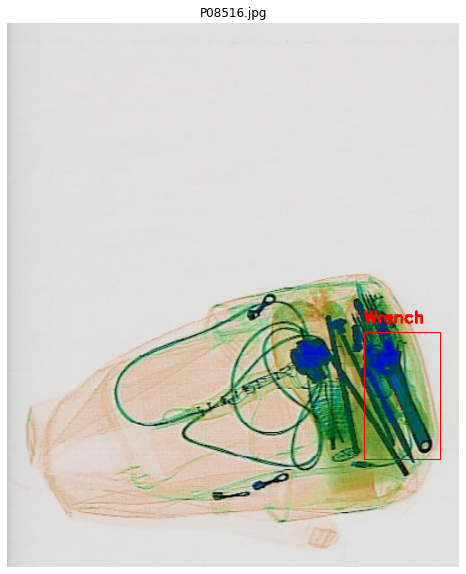

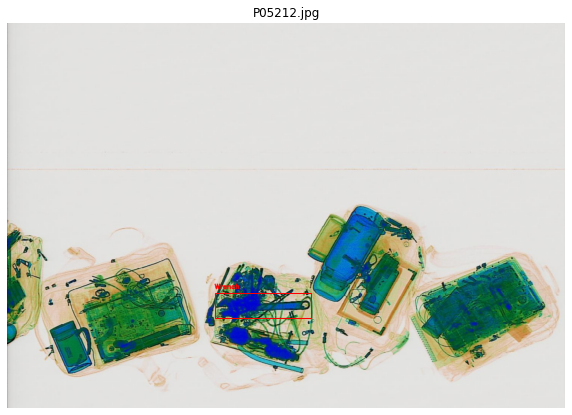

In [ ]:
def draw_img_with_box(df, df_index):
    df['bboxes_name'] = df[['xmin', 'ymin', 'xmax', 'ymax',
                            'name_class']].apply(list, axis=1)
    df = df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax', 'class', 'name_class',
                          'width', 'height', 'depth']).groupby('images',
                                                               as_index=False).agg(list)
    img = cv2.imread(f"/content/dataset/{df.loc[df_index, 'images']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    fig, ax = plt.subplots(figsize=(10, 10))
    boxes_name = df.loc[df_index, 'bboxes_name']
    for bbox in boxes_name:
        rect = patches.Rectangle((int(bbox[0]), int(bbox[1])),
                                 int(bbox[2]) - int(bbox[0]),
                                 int(bbox[3]) - int(bbox[1]),
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cv2.putText(img, bbox[4], (int(bbox[0]), int(bbox[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    ax.imshow(img)
    plt.title(df.loc[df_index, 'images'])
    ax.axis('off')
    plt.show()


for _ in range(2):
    draw_img_with_box(positive_img_df, randint(0, len(images)))

## –ù–∞—Ö–æ–∂–¥–µ–Ω–∏–µ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫ –¥–ª—è —à–∏—Ä–∏–Ω—ã –∏ –≤—ã—Å–æ—Ç—ã

In [ ]:
positive_img_df.info()

print(f'–ú–∏–Ω–∏–º—É–º —à–∏—Ä–∏–Ω—ã: {int(positive_img_df.width.min())}.\n\
–ú–∏–Ω–∏–º—É–º –≤—ã—Å–æ—Ç—ã: {int(positive_img_df.height.min())}.\n\
–ú–∞–∫—Å–∏–º—É–º —à–∏—Ä–∏–Ω—ã: {int(positive_img_df.width.max())}.\n\
–ú–∞–∫—Å–∏–º—É–º –≤—ã—Å–æ—Ç—ã: {int(positive_img_df.height.max())}.\n\
–ú–µ–¥–∏–∞–Ω–∞ —à–∏—Ä–∏–Ω—ã: {int(positive_img_df.width.median())}.\n\
–ú–µ–¥–∏–∞–Ω–∞ –≤—ã—Å–æ—Ç—ã: {int(positive_img_df.height.median())}.\n\
–°—Ä–µ–¥–Ω–µ–µ —à–∏—Ä–∏–Ω—ã: {int(positive_img_df.width.mean())}.\n\
–°—Ä–µ–¥–Ω–µ–µ –≤—ã—Å–æ—Ç—ã: {int(positive_img_df.height.mean())}.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17491 entries, 0 to 17490
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   images       17491 non-null  object
 1   xmin         17491 non-null  int64 
 2   ymin         17491 non-null  int64 
 3   xmax         17491 non-null  int64 
 4   ymax         17491 non-null  int64 
 5   class        17491 non-null  int64 
 6   name_class   17491 non-null  object
 7   width        17491 non-null  int64 
 8   height       17491 non-null  int64 
 9   depth        17491 non-null  int64 
 10  bboxes_name  17491 non-null  object
dtypes: int64(8), object(3)
memory usage: 1.5+ MB
–ú–∏–Ω–∏–º—É–º —à–∏—Ä–∏–Ω—ã: 144.
–ú–∏–Ω–∏–º—É–º –≤—ã—Å–æ—Ç—ã: 151.
–ú–∞–∫—Å–∏–º—É–º —à–∏—Ä–∏–Ω—ã: 1035.
–ú–∞–∫—Å–∏–º—É–º –≤—ã—Å–æ—Ç—ã: 1536.
–ú–µ–¥–∏–∞–Ω–∞ —à–∏—Ä–∏–Ω—ã: 577.
–ú–µ–¥–∏–∞–Ω–∞ –≤—ã—Å–æ—Ç—ã: 654.
–°—Ä–µ–¥–Ω–µ–µ —à–∏—Ä–∏–Ω—ã: 582.
–°—Ä–µ–¥–Ω–µ–µ –≤—ã—Å–æ—Ç—ã: 680.


### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è

#### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π —à–∏—Ä–∏–Ω—ã

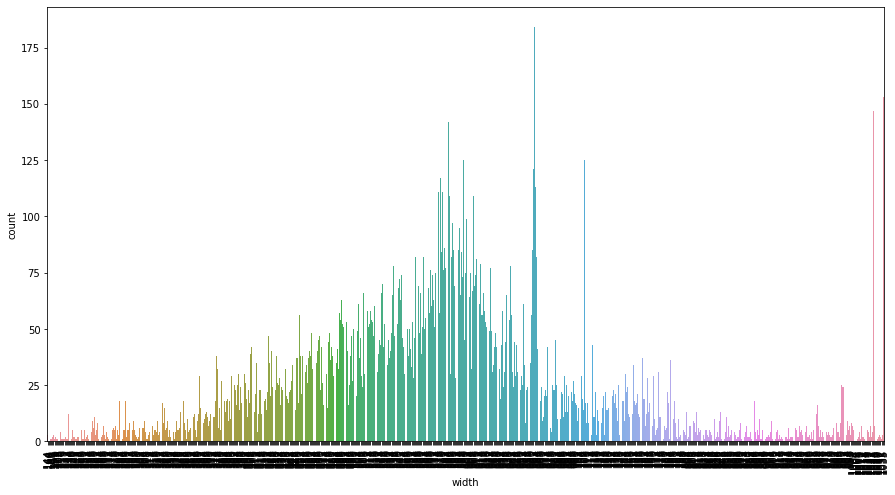

In [ ]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='width', data=positive_img_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
None

#### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –≤—ã—Å–æ—Ç—ã

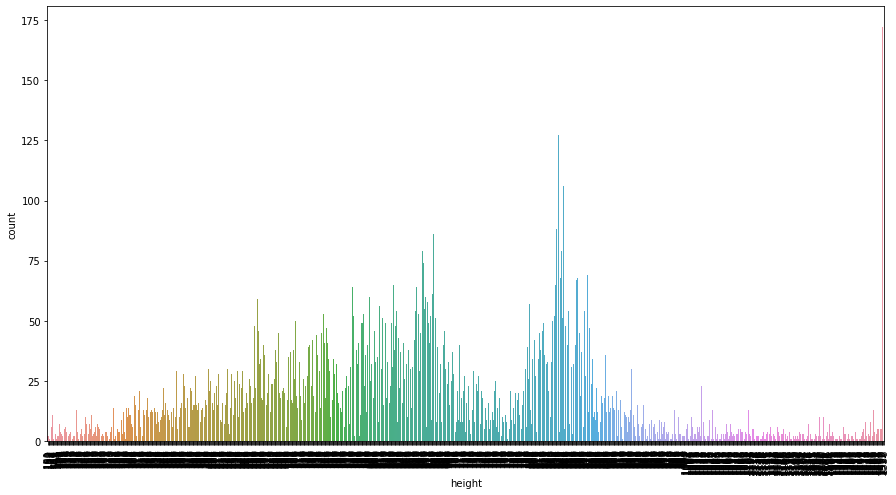

In [ ]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='height', data=positive_img_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
None

#### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π —à–∏—Ä–∏–Ω—ã, —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö –ø–æ –≥—Ä—É–ø–ø–∞–º

In [ ]:
def lvls_size(size, name_size):
    all_lvls_size_list = []
    lvl_140_250 = []
    lvl_250_350 = []
    lvl_350_450 = []
    lvl_450_550 = []
    lvl_550_650 = []
    lvl_650_750 = []
    lvl_750_850 = []
    lvl_850_950 = []
    lvl_950_1050 = []
    lvl_1050_1150 = []
    lvl_1150_1250 = []
    lvl_1250_1350 = []
    lvl_1350_1450 = []
    lvl_1450_1550 = []

    for i in size:
        if i >= 140 and i <= 250:
            lvl_140_250.append('140-250')
        elif i > 250 and i <= 350:
            lvl_250_350.append('250-350')
        elif i > 350 and i <= 450:
            lvl_350_450.append('350-450')
        elif i > 450 and i <= 550:
            lvl_450_550.append('450-550')
        elif i > 550 and i <= 650:
            lvl_550_650.append('550-650')
        elif i > 650 and i <= 750:
            lvl_650_750.append('650-750')
        elif i > 750 and i <= 850:
            lvl_750_850.append('750-850')
        elif i > 850 and i <= 950:
            lvl_850_950.append('850-950')
        elif i > 950 and i <= 1050:
            lvl_950_1050.append('950-1050')
        elif i > 1050 and i <= 1150:
            lvl_1050_1150.append('1050-1150')
        elif i > 1150 and i <= 1250:
            lvl_1150_1250.append('1150-1250')
        elif i > 1250 and i <= 1350:
            lvl_1250_1350.append('1250-1350')
        elif i > 1350 and i <= 1450:
            lvl_1350_1450.append('1350-1450')
        elif i > 1450 and i <= 1550:
            lvl_1450_1550.append('1450-1550')

    all_lvls_size_list.extend(lvl_140_250)
    all_lvls_size_list.extend(lvl_250_350)
    all_lvls_size_list.extend(lvl_350_450)
    all_lvls_size_list.extend(lvl_450_550)
    all_lvls_size_list.extend(lvl_550_650)
    all_lvls_size_list.extend(lvl_650_750)
    all_lvls_size_list.extend(lvl_750_850)
    all_lvls_size_list.extend(lvl_850_950)
    all_lvls_size_list.extend(lvl_950_1050)
    all_lvls_size_list.extend(lvl_1050_1150)
    all_lvls_size_list.extend(lvl_1150_1250)
    all_lvls_size_list.extend(lvl_1250_1350)
    all_lvls_size_list.extend(lvl_1350_1450)
    all_lvls_size_list.extend(lvl_1450_1550)

    df = pd.DataFrame(columns=[name_size], data=all_lvls_size_list)
    plt.figure(figsize=(15, 8))
    sns.countplot(x=name_size, data=df)

    return df

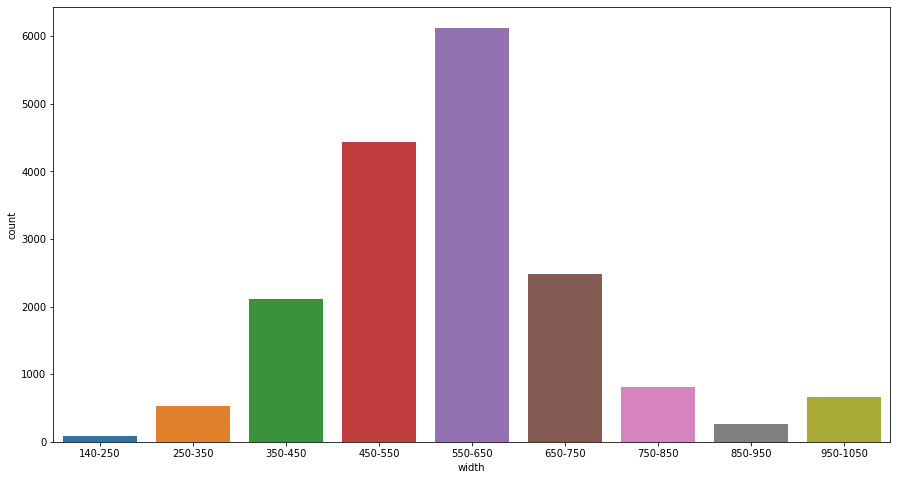

In [ ]:
df_lvl_width = lvls_size(positive_img_df.width.to_list(), 'width')

#### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –≤—ã—Å–æ—Ç—ã, —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö –ø–æ –≥—Ä—É–ø–ø–∞–º

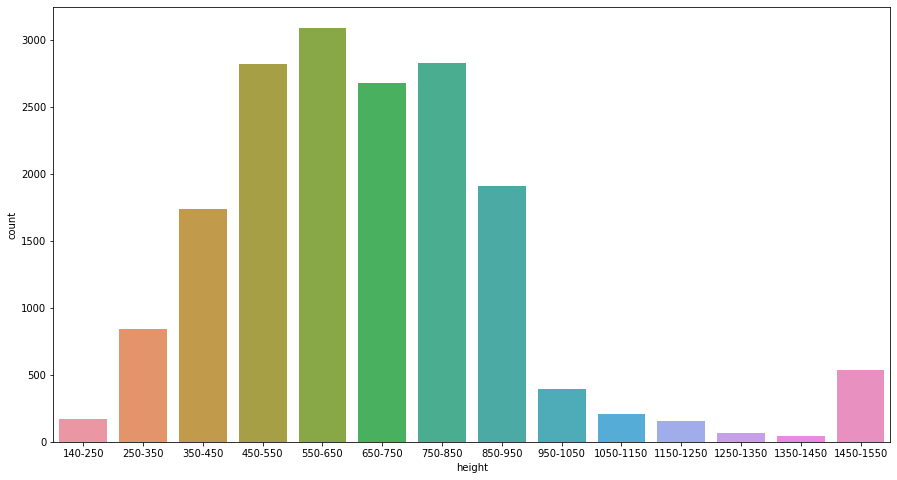

In [ ]:
df_lvl_height = lvls_size(positive_img_df.height.to_list(), 'height')

#### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π —à–∏—Ä–∏–Ω—ã –∏ –≤—ã—Å–æ—Ç—ã, —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö –ø–æ –≥—Ä—É–ø–ø–∞–º

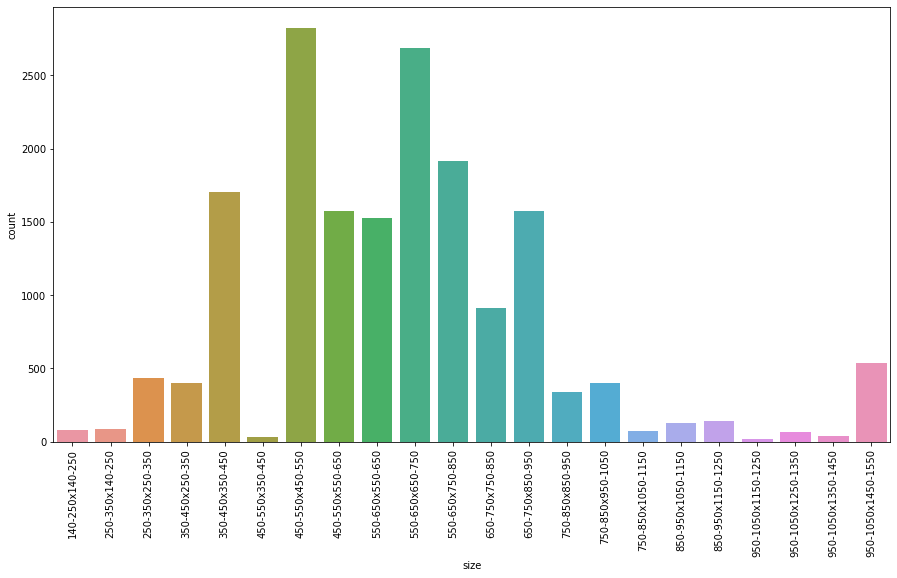

In [ ]:
all_lvl_size_df = pd.merge(df_lvl_width, df_lvl_height, left_index=True, right_index=True)
all_lvl_size_df['size'] = all_lvl_size_df['width'].astype(str) + 'x' + all_lvl_size_df['height'].astype(str)

plt.figure(figsize=(15, 8))
ax = sns.countplot(x='size', data=all_lvl_size_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
None

## –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [ ]:
count_classes = positive_img_df['name_class'].value_counts()
print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–≤—Ç–æ—Ä–æ–≤ –∫–∞—Ç–µ–≥–æ—Ä–∏–π:\n{count_classes}\n\
–°—Ä–µ–¥–Ω–µ–µ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º: {count_classes.mean()}\n\
–ú–µ–¥–∏–∞–Ω–∞ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º: {count_classes.median()}\n')

print(f"–°–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç—å –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å Pilers (—Å–∞–º—ã–º –±–æ–ª—å—à–∏–º –∫–ª–∞—Å—Å–æ–º) (%):\n\
Gun: {count_classes['Gun'] * 100 / count_classes['Pliers']}\n\
Wrench: {count_classes['Wrench'] * 100 / count_classes['Pliers']}\n\
Knife: {count_classes['Knife'] * 100 / count_classes['Pliers']}\n\
Scissors: {count_classes['Scissors'] * 100 / count_classes['Pliers']}\n")

print(f"–°–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç—å –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –æ–±—â–∏–º –∫–æ–ª-–≤–æ–º –æ–±—ä–µ–∫—Ç–æ–≤ (%):\n\
Pliers: {count_classes['Pliers'] * 100 / len(positive_img_df['images'])}\n\
Gun: {count_classes['Gun'] * 100 / len(positive_img_df['images'])}\n\
Wrench: {count_classes['Wrench'] * 100 / len(positive_img_df['images'])}\n\
Knife: {count_classes['Knife'] * 100 / len(positive_img_df['images'])}\n\
Scissors: {count_classes['Scissors'] * 100 / len(positive_img_df['images'])}\n")

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–≤—Ç–æ—Ä–æ–≤ –∫–∞—Ç–µ–≥–æ—Ä–∏–π:
Pliers      5368
Gun         4863
Wrench      3076
Knife       3055
Scissors    1129
Name: name_class, dtype: int64
–°—Ä–µ–¥–Ω–µ–µ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º: 3498.2
–ú–µ–¥–∏–∞–Ω–∞ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º: 3076.0

–°–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç—å –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å Pilers (—Å–∞–º—ã–º –±–æ–ª—å—à–∏–º –∫–ª–∞—Å—Å–æ–º) (%):
Gun: 90.59239940387481
Wrench: 57.30253353204173
Knife: 56.91132637853949
Scissors: 21.03204172876304

–°–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç—å –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –æ–±—â–∏–º –∫–æ–ª-–≤–æ–º –æ–±—ä–µ–∫—Ç–æ–≤ (%):
Pliers: 30.690069178434623
Gun: 27.802870047452977
Wrench: 17.586187181979305
Knife: 17.466125435938483
Scissors: 6.454748156194614



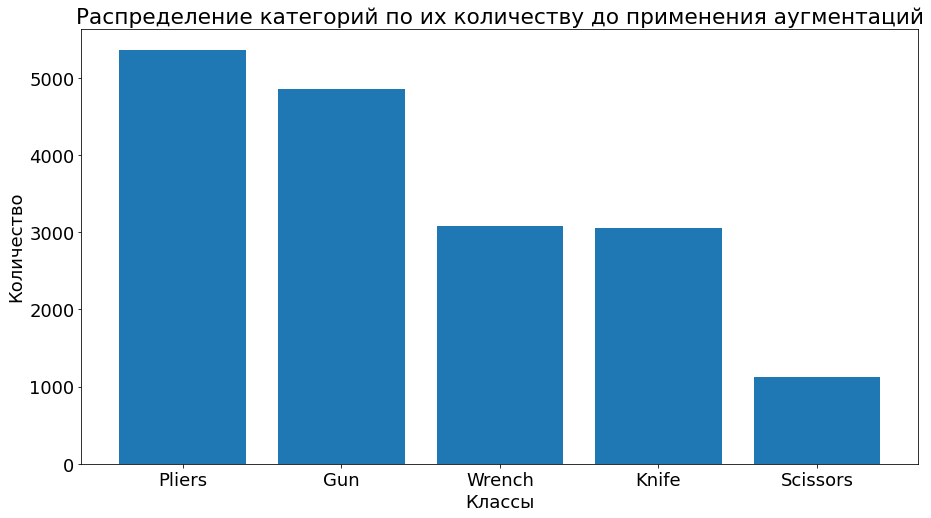

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 8))
vals_counts = positive_img_df['name_class'].value_counts().to_dict()
plt.bar(list(vals_counts.keys()), list(vals_counts.values()))
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ')
plt.xlabel('–ö–ª–∞—Å—Å—ã')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–π –ø–æ –∏—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –¥–æ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π')
None

# C–±–æ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ (DataFrame'a), –≤–∫–ª—é—á–∞—é—â–∏–π –±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫—É –∫–ª–∞—Å—Å–æ–≤ –∑–∞ —Å—á–µ—Ç –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π –∫ –¥–∞–Ω–Ω—ã–º

In [ ]:
!git clone https: // github.com / Paperspace / DataAugmentationForObjectDetection
shutil.move('/content/DataAugmentationForObjectDetection/data_aug', '/content')

Cloning into 'DataAugmentationForObjectDetection'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 141 (delta 10), reused 8 (delta 8), pack-reused 122
Receiving objects: 100% (141/141), 10.19 MiB | 19.84 MiB/s, done.
Resolving deltas: 100% (22/22), done.


'/content/data_aug'

In [ ]:
from data_aug.data_aug import *
from data_aug.bbox_util import *

TRANSFORM = [
    RandomHorizontalFlip(0.5),
    # RandomScale(0.2, diff=True), 
    RandomRotate(10),
    # RandomTranslate,
    # RandomShear,
    # RandomHSV(saturation = 100, brightness = None),
    # Resize(640)
]

## –°–æ–∑–¥–∞–Ω–∏–µ –ø–æ–∑–∏—Ç–∏–≤–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [ ]:
def df_positive_without_aug():
    info_all_imgs = []
    pbar = tqdm.tqdm(os.listdir(PATH_POSITIVE_IMGS))
    for img in pbar:
        xml_path = f'/content/Annotation/{img[:-4]}.xml'
        tree = ET.parse(xml_path)
        root = tree.getroot()

        if root.findall('object') != []:
            for member in root.findall('object'):
                if member.find('bndbox') is None or member.find('name') is None:
                    continue
                obj = [img,
                       float(member.find('bndbox').find('xmin').text),
                       float(member.find('bndbox').find('ymin').text),
                       float(member.find('bndbox').find('xmax').text),
                       float(member.find('bndbox').find('ymax').text),
                       CLASSES.index(member.find('name').text),
                       member.find('name').text]
                info_all_imgs.append(obj)

    df_positive = pd.DataFrame(
        columns=['images', 'xmin', 'ymin', 'xmax', 'ymax', 'class',
                 'name_class'], data=info_all_imgs)
    df_positive['bboxes_name'] = df_positive[['xmin', 'ymin', 'xmax',
                                              'ymax', 'class']].apply(list, axis=1)
    df_positive = df_positive.drop(columns=['xmin', 'ymin', 'xmax',
                                            'ymax', 'class']).groupby('images',
                                                                      as_index=False).agg(list)
    df_positive['bboxes_name'] = df_positive['bboxes_name'].apply(
        lambda x: np.array(x)
    )

    return df_positive


df_positive = df_positive_without_aug()
df_positive.head()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8827/8827 [00:01<00:00, 7991.50it/s]


images      name_class  \
0  P00001.jpg  [Knife, Knife]   
1  P00002.jpg  [Knife, Knife]   
2  P00003.jpg         [Knife]   
3  P00004.jpg         [Knife]   
4  P00005.jpg         [Knife]   

                                         bboxes_name  
0  [[192.964, 204.205, 581.489, 367.696, 1.0], [1...  
1  [[224.931, 223.965, 695.15, 463.01, 1.0], [194...  
2        [[844.442, 123.847, 918.607, 315.921, 1.0]]  
3         [[17.318, 144.239, 355.424, 302.372, 1.0]]  
4        [[115.731, 132.028, 209.601, 429.824, 1.0]]

## –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞—Ç–∞—Å–µ—Ç–∞ –Ω–∞ —Ç—É —á–∞—Å—Ç—å, –∫ –∫–æ—Ç–æ—Ä–æ–π —Ç—Ä–µ–±—É–µ—Ç—Å—è –ø—Ä–∏–º–µ–Ω–∏—Ç—å –±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫—É –¥–∞–Ω–Ω—ã—Ö –∑–∞ —Å—á–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π –∫ –¥–∞–Ω–Ω—ã–º –∏ –Ω–∞ —Ç—É, –≥–¥–µ —ç—Ç–æ–≥–æ –Ω–µ —Ç—Ä–µ–±—É–µ—Ç—Å—è

In [ ]:
def make_only_one_class_in_img_df(df, name_class):
    all_names = df['name_class'].to_list()
    total_data = []
    for i in range(len(all_names)):
        if (len(set(all_names[i])) == 1 and
                list(set(all_names[i]))[0] == name_class):
            total_data.append([df.loc[i, 'images'],
                               df.loc[i, 'name_class'],
                               df.loc[i, 'bboxes_name']])
            df_new = pd.DataFrame(columns=[f'images', 'name_class', 'bboxes_name'],
                                  data=total_data)
            # df_new['bboxes_name'] = df_new['bboxes_name'].apply(lambda x: x.astype('float64'))
    return df_new


def make_df_without_disbalance_class(df, uniq_df):
    disb_imgs = uniq_df.images.to_list()

    return df[~df['images'].isin(disb_imgs)]



In [ ]:
scissors_only_df = make_only_one_class_in_img_df(df_positive, 'Scissors')
df_without_disb_class = make_df_without_disbalance_class(df_positive, scissors_only_df)

## –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–π –∫ –¥–∞–Ω–Ω—ã–º –∏ —Å–±–æ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞

In [ ]:
def augmentation(df, path_to_save):
    total_data = []
    if not os.path.isdir(path_to_save):
        os.mkdir(path_to_save)

    for i in tqdm.trange(len(df)):
        img_name = df.loc[i, 'images']
        cl_names = df.loc[i, 'name_class']
        aug_bboxes = df.loc[i, 'bboxes_name']

        img = cv2.imread(os.path.join(PATH_POSITIVE_IMGS, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

        new_img, new_bboxes_name = Sequence(TRANSFORM)(img, aug_bboxes)
        new_img_name = f"{img_name.split('.')[0]}_aug.jpg"

        cv2.imwrite(os.path.join(path_to_save, new_img_name), new_img)

        total_data.append([new_img_name, cl_names, new_bboxes_name])

    return pd.DataFrame(columns=['images', 'name_class', 'bboxes_name'],
                        data=total_data)


aug_df = augmentation(scissors_only_df, PATH_POSITIVE_IMGS)
aug_df.head()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 885/885 [00:14<00:00, 62.38it/s]


images  name_class  \
0  P03036_aug.jpg  [Scissors]   
1  P03760_aug.jpg  [Scissors]   
2  P03761_aug.jpg  [Scissors]   
3  P03762_aug.jpg  [Scissors]   
4  P03763_aug.jpg  [Scissors]   

                                         bboxes_name  
0  [[4.706261394529748, 17.836616418454575, 233.6...  
1  [[265.315738745071, 467.64151620171566, 300.83...  
2  [[264.49414815935944, 398.57153278775314, 304....  
3  [[243.23953468390292, 343.50964103509926, 281....  
4  [[75.6901628610159, 398.7481660189635, 113.778...

## –°–æ–∑–¥–∞–Ω–∏–µ DataFrame'a —Å bounding box YOLO —Ñ–æ—Ä–º–∞—Ç–∞

### –°–æ–∑–¥–∞–Ω–∏–µ —Ü–µ–ª–æ–≥–æ –ø–æ–∑–∏—Ç–∏–≤–Ω–æ–≥–æ DataFrame'a

In [ ]:
total_positive_df_without_yoloBboxes = pd.concat((scissors_only_df, aug_df,
                                                  df_without_disb_class), axis=0)
total_positive_df_without_yoloBboxes.index = range(len(total_positive_df_without_yoloBboxes))
total_positive_df_without_yoloBboxes.head()

images  name_class                                        bboxes_name
0  P03036.jpg  [Scissors]           [[1.493, 20.334, 234.701, 129.604, 4.0]]
1  P03760.jpg  [Scissors]        [[267.175, 494.647, 303.188, 559.462, 4.0]]
2  P03761.jpg  [Scissors]  [[267.66200000000003, 411.306, 307.081, 484.07...
3  P03762.jpg  [Scissors]  [[266.478, 338.141, 304.33799999999997, 400.53...
4  P03763.jpg  [Scissors]          [[78.557, 417.202, 115.639, 483.56, 4.0]]

In [ ]:
def create_yolo_df(df):
    total_data = []

    def convert_to_yolo_bbox(bbox, w, h):
        x_center = ((bbox[2] + bbox[0]) / 2) / w
        y_center = ((bbox[3] + bbox[1]) / 2) / h
        width = (bbox[2] - bbox[0]) / w
        height = (bbox[3] - bbox[1]) / h
        return x_center, y_center, width, height

    for i in tqdm.trange(len(df)):
        img_name = df.loc[i, 'images']
        cl_names = df.loc[i, 'name_class']
        bboxes_name = df.loc[i, 'bboxes_name']

        img = cv2.imread(os.path.join(PATH_POSITIVE_IMGS, img_name))
        height, width, _ = img.shape

        new_names_bboxes = []
        for bbox_name in bboxes_name:
            bbox = bbox_name[:4]
            class_obj = bbox_name[-1]
            x_center, y_center, w, h = convert_to_yolo_bbox(bbox,
                                                            width, height)
            new_names_bboxes.append([class_obj, x_center, y_center, w, h])

        total_data.append([img_name, cl_names, new_names_bboxes])

    positive_df = pd.DataFrame(columns=['images', 'name_class', 'bboxes_name'],
                               data=total_data)

    if INCLUDE_NO_OBJECT_IMGS:
        negative_images_names_list = os.listdir(PATH_NEGATIVE_IMGS)
        count_negative_imgs = int(len(negative_images_names_list) * INCLUDE_NO_OBJECT_IMGS)
        # shuffle(negative_images_names_list)
        negative_images_names_list = negative_images_names_list[:count_negative_imgs]
        name_class_list = ['background'] * len(negative_images_names_list)

        negative_df = pd.DataFrame({'images': negative_images_names_list,
                                    'name_class': name_class_list})

        full_df = pd.concat((positive_df, negative_df), axis=0)
        full_df = full_df.sample(frac=1)
        full_df.index = range(len(full_df))

        return full_df

    positive_df = positive_df.sample(frac=1)
    positive_df.index = range(len(positive_df))

    return positive_df


df_full_yolo = create_yolo_df(total_positive_df_without_yoloBboxes)

df_full_yolo.head()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9691/9691 [00:49<00:00, 197.61it/s]


images             name_class  \
0      P08247.jpg               [Pliers]   
1  P03826_aug.jpg             [Scissors]   
2      P02129.jpg  [Gun, Pliers, Wrench]   
3    N0009747.jpg             background   
4      P01051.jpg     [Gun, Gun, Pliers]   

                                         bboxes_name  
0  [[3.0, 0.45806985294117647, 0.2444959677419355...  
1  [[4.0, 0.7051405186695563, 0.7883503233722347,...  
2  [[0.0, 0.5330372424722662, 0.6326769383697812,...  
3                                                NaN  
4  [[0.0, 0.6048288177339901, 0.27694086021505376...

## –°–æ–∑–¥–∞–Ω–∏–µ –µ–¥–∏–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [ ]:
def copy_dataset_in_one_folder():
    folder = 'full_dataset'
    if not os.path.isdir(folder):
        os.mkdir(folder)

    for name in os.listdir(PATH_POSITIVE_IMGS):
        shutil.copy(os.path.join(PATH_POSITIVE_IMGS, name), folder)

    negative_images_names_list = os.listdir(PATH_NEGATIVE_IMGS)
    count_negative_imgs = int(len(negative_images_names_list) * INCLUDE_NO_OBJECT_IMGS)
    negative_images_names_list = negative_images_names_list[:count_negative_imgs]
    for name in negative_images_names_list:
        shutil.copy(os.path.join(PATH_NEGATIVE_IMGS, name), folder)

    return folder


if INCLUDE_NO_OBJECT_IMGS:
    full_dataset_path = copy_dataset_in_one_folder()
else:
    full_dataset_path = PATH_POSITIVE_IMGS

## –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –≤—ã–±–æ—Ä–∫–∏ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é, –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –∏ —Ç–µ—Å—Ç–æ–≤—É—é

In [ ]:
train_val_df, test_df = train_test_split(df_full_yolo, test_size=TEST_SIZE,
                                         random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE,
                                    random_state=RANDOM_STATE)

In [ ]:
data_path = os.path.join(os.getcwd(), 'yolov7_dataset')

train_path = os.path.join(data_path, 'train')
train_images_path = os.path.join(train_path, 'images')
train_labels_path = os.path.join(train_path, 'labels')

val_path = os.path.join(data_path, 'val')
val_images_path = os.path.join(val_path, 'images')
val_labels_path = os.path.join(val_path, 'labels')

test_path = os.path.join(data_path, 'test')
test_images_path = os.path.join(test_path, 'images')
test_labels_path = os.path.join(test_path, 'labels')

if not os.path.isdir(data_path):
    os.mkdir(data_path)

if not os.path.isdir(train_path):
    os.mkdir(train_path)
if not os.path.isdir(train_images_path):
    os.mkdir(train_images_path)
if not os.path.isdir(train_labels_path):
    os.mkdir(train_labels_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)
if not os.path.isdir(val_images_path):
    os.mkdir(val_images_path)
if not os.path.isdir(val_labels_path):
    os.mkdir(val_labels_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)
if not os.path.isdir(test_images_path):
    os.mkdir(test_images_path)
if not os.path.isdir(test_labels_path):
    os.mkdir(test_labels_path)

for img in train_df.images.to_list():
    shutil.copy(os.path.join(full_dataset_path, img), train_images_path)

for img in val_df.images.to_list():
    shutil.copy(os.path.join(full_dataset_path, img), val_images_path)

for img in test_df.images.to_list():
    shutil.copy(os.path.join(full_dataset_path, img), test_images_path)

In [ ]:
train_df.index = range(len(train_df))
test_df.index = range(len(test_df))
val_df.index = range(len(val_df))

In [ ]:
def create_labels_files(df, label_path):
    for row in tqdm.trange(len(df)):
        name = df.loc[row, 'images'][:-3]
        with open(os.path.join(label_path, f'{name}txt'), 'w') as file:
            if name.startswith('N'):
                file.write(' ')
            else:
                text = ''
                for name_bbox in df.loc[row, 'bboxes_name']:
                    text += f'{int(name_bbox[0])} {name_bbox[1]} {name_bbox[2]} {name_bbox[3]} {name_bbox[4]}\n'
                file.write(text[:-1])


create_labels_files(train_df, train_labels_path)
create_labels_files(val_df, val_labels_path)
create_labels_files(test_df, test_labels_path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3552/3552 [00:00<00:00, 6960.27it/s]


## –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ, —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–æ–≤

In [ ]:
def check_divided_df(df, name_df):
    positive_images = []
    negative_images = []
    uncertain_files = []
    all_classes = []
    for img_names in df.images.to_list():
        if img_names.startswith('P'):
            all_classes.extend(df[df['images'] == img_names]
                               ['name_class'].to_list()[0])
            positive_images.append(img)
        elif img_names.startswith('N'):
            negative_images.append(img)
        else:
            uncertain_files.append(img)

    print(f'{name_df}: \n\
    –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {len(df.images.to_list())}, \n\
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {len(positive_images)} —à—Ç., \n\
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {len(negative_images)} —à—Ç., \n\
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Ñ–∞–π–ª–æ–≤: {len(uncertain_files)} —à—Ç.\n\n\
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Å–µ—Ö –∫–ª–∞—Å—Å–æ–≤: {len(all_classes)} \n\
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤: {dict(Counter(all_classes))}\n')

    total = dict(Counter(all_classes))
    total['background'] = len(negative_images)

    return total


dict_count_classes_in_divided_df = {
    'train': check_divided_df(train_df, 'train_df'),
    'test': check_divided_df(test_df, 'test_df'),
    'val': check_divided_df(val_df, 'val_df')
}

train_df: 
    –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 6214, 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 5070 —à—Ç., 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 1144 —à—Ç., 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Ñ–∞–π–ª–æ–≤: 0 —à—Ç.

    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Å–µ—Ö –∫–ª–∞—Å—Å–æ–≤: 9733 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤: {'Gun': 2501, 'Pliers': 2850, 'Scissors': 1121, 'Wrench': 1643, 'Knife': 1618}

test_df: 
    –û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 3552, 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 2926 —à—Ç., 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: 626 —à—Ç., 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Ñ–∞–π–ª–æ–≤: 0 —à—Ç.

    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—Å–µ—Ö –∫–ª–∞—Å—Å–æ–≤: 5526 
    –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤: {'Wrench': 917, 'Pliers': 1592, 'Gun': 1485, 'Sc

### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è

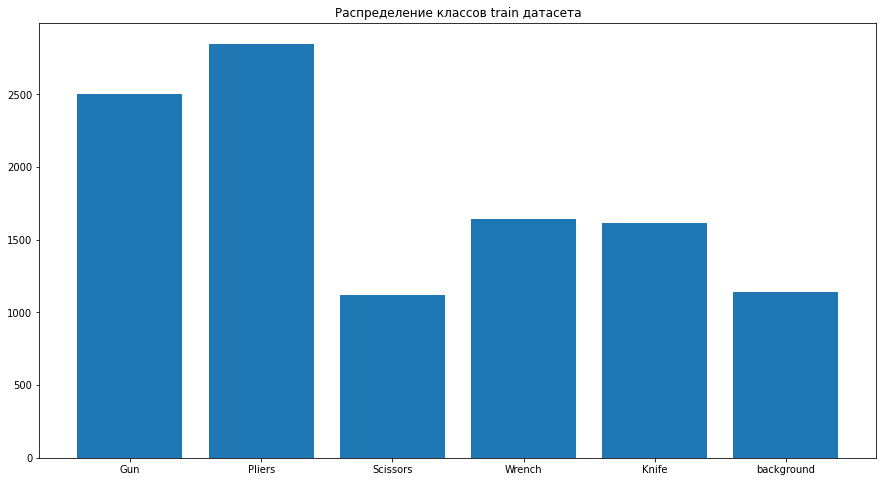

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(*zip(*dict_count_classes_in_divided_df['train'].items()))
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ train –¥–∞—Ç–∞—Å–µ—Ç–∞')
None

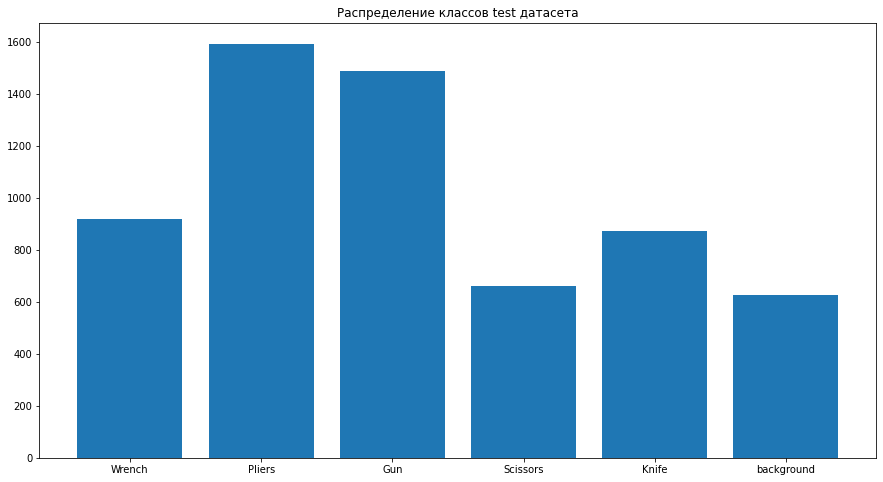

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(*zip(*dict_count_classes_in_divided_df['test'].items()))
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ test –¥–∞—Ç–∞—Å–µ—Ç–∞')
None

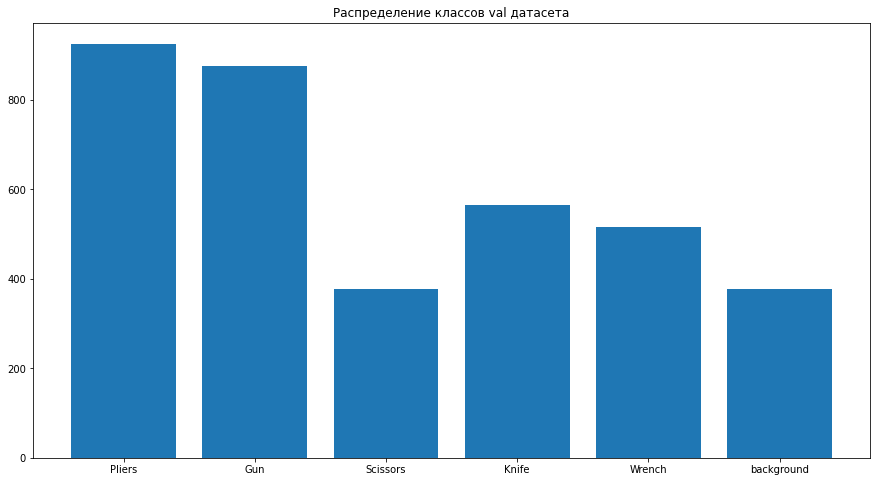

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(*zip(*dict_count_classes_in_divided_df['val'].items()))
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ val –¥–∞—Ç–∞—Å–µ—Ç–∞')
None

## –°–∫–∞—á–∏–≤–∞–Ω–∏–µ YOLOv7

In [ ]:
! git clone https: // github.com / WongKinYiu / yolov7.git
! pip install -r./ yolov7 / requirements.txt
# ! wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt \
#         -P /content/yolov7
! wget https: // github.com / WongKinYiu / yolov7 / releases / download / v0.1 / yolov7-tiny.pt
-P / content / yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 1133, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1133 (delta 0), reused 1 (delta 0), pack-reused 1130
Receiving objects: 100% (1133/1133), 69.94 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (523/523), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 60.3 MB/s eta 0:00:00
--2023-03-19 09:42:10--  https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/511187726/ba7d01ee-125a-4134-8864-fa1abcbf94d5?X-

## –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –∫–æ–Ω—Ñ–∏–≥–∞

In [ ]:
# CFG_USE = '/content/yolov7/cfg/training/yolov7.yaml'
CFG_USE = '/content/yolov7/cfg/training/yolov7-tiny.yaml'

with open(CFG_USE, 'r') as f:
    yolo_text = f.read()

new_yolo_text = yolo_text.replace('nc: 80', f'nc: {len(CLASSES)}')
with open(os.path.join(os.getcwd(), 'yolov7', 'cfg', 'training', 'cfg_yolov7_baggage.yaml'), 'w') as f:
    f.write(new_yolo_text)

config = {'train': train_path,
          'val': val_path,
          'test': test_path,
          'nc': len(CLASSES),
          'names': list(CLASSES)}

with open(os.path.join(os.getcwd(), 'yolov7', 'data', 'data_baggage.yaml'), "w") as file:
    yaml.dump(config, file, default_flow_style=False)

In [ ]:
# !zip -r /content/drive/MyDrive/Baggage/yolov7_dataset /content/yolov7_dataset
# shutil.copy('/content/yolov7/data/data_baggage.yaml', '/content/drive/MyDrive/Baggage')
# shutil.copy('/content/yolov7/cfg/training/cfg_yolov7_baggage.yaml', '/content/drive/MyDrive/Baggage')

In [ ]:
! pip install wandb
! wandb disabled

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.0/2.0 MB 69.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 184.3/184.3 KB 19.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 189.1/189.1 KB 22.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62.7/62.7 KB 4.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=fab510b5895a370163e3f9dc711628b4c70e2f7907f65e343d344516bc3ac2e9
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75

# –û–±—É—á–µ–Ω–∏–µ YOLOv7

## –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏

In [ ]:
! wget https: // github.com / WongKinYiu / yolov7 / releases / download / v0.1 / yolov7.pt -P / content / yolov7

In [ ]:
# –≠—Ç–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –æ–±—ã—á–Ω–æ –Ω–µ –º–µ–Ω—è—é—Ç—Å—è
BATCH_SIZE = 4
WORKERS = 8
# DATA = '/content/drive/MyDrive/Baggage/data_baggage.yaml'
DATA = '/content/yolov7/data/data_baggage.yaml'

# –° —ç—Ç–∏–º–∏ –ø–∞—Ä–º–µ—Ç—Ä–∞–º–∏ –ø–æ—ç–∫—Å–ø–µ—Ä–µ–º–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å
EPOCHS = 150
# WEIGHTS = '/content/yolov7/yolov7.pt'
# WEIGHTS = '/content/drive/MyDrive/Baggage/baggage_detection/Epochs:100_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False/weights/last.pt'
WEIGHTS = '/content/yolov7/yolov7-tiny.pt'
# WEIGHTS = '/content/drive/MyDrive/Baggage/baggage_detection/YOLOV7-TINY/EPOCH:133_CFG:cfg_yolov7_baggage.yaml_WEIGHTS:last.pt_HYP:hyp.scratch.custom.yaml_RESIZE:False_WITHOUT-END2END2/weights/last.pt'
# HYP = '/content/yolov7/data/hyp.scratch.custom.yaml'
# HYP = '/content/drive/MyDrive/Baggage/baggage_detection/epochs_50__cfg_yolov7.yaml__weights_yolov7.pt__hyp_hyp.scratch.custom.yaml__resize_False/hyp.yaml'
# HYP = '/content/yolov7/data/hyp.scratch.tiny.yaml'
HYP = '/content/yolov7/data/hyp.scratch.custom.yaml'

# CFG = '/content/drive/MyDrive/Baggage/cfg_yolov7_baggage.yaml'
CFG = '/content/yolov7/cfg/training/cfg_yolov7_baggage.yaml'

# –ò–º–µ–Ω–∞ –ø—Ä–æ–µ–∫—Ç–∞ –∏ –¥–∞–Ω–Ω–æ–≥–æ –∑–∞–ø—É—Å–∫–∞
# PROJECT = "/content/drive/MyDrive/Baggage/baggage_detection"
PROJECT = "/content/drive/MyDrive/Baggage/baggage_detection/YOLOV7-TINY"
if RESIZE_IMAGES:

    # –≠—Ç–æ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä –º–µ–Ω—è—é—Ç—Å—è —Ä–µ–¥–∫–æ
    IMG_SIZE = RESIZE_IMAGES

else:

    # –≠—Ç–æ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä –º–µ–Ω—è—é—Ç—Å—è —Ä–µ–¥–∫–æ
    IMG_SIZE = 640

RUN_NAME = f"EPOCH:{EPOCHS}_CFG:{CFG.split('/')[-1]}_WEIGHTS:{WEIGHTS.split('/')[-1]}_HYP:{HYP.split('/')[-1]}_RESIZE:{RESIZE_IMAGES}_WITHOUT-END2END"

% cd yolov7

/content/yolov7


## –û–±—É—á–µ–Ω–∏–µ

In [ ]:
# TINY

# –ú–∞–Ω–∏–ø—É–ª–∏—Ä–æ–≤–∞—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–º --multi-scale –¥–ª—è —Å—Ç–∞—Ç–∏—á–Ω–æ–≥–æ –∏ –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–æ–≥–æ 
# —Ä–∞–∑–º–µ—Ä–∞ –≤—Å–µ—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π (–µ—Å–ª–∏ RESIZE_IMAGES == False, —Ç–æ –≤—Å—Ç–∞–≤–∏—Ç—å --multi-scale,
# –µ—Å–ª–∏  RESIZE_IMAGES != False, —Ç–æ —É–±—Ä–∞—Ç—å --multi-scale)
! wandb disabled

!python /content/yolov7/train.py --workers {WORKERS} --device 0 --img-size {IMG_SIZE}\
--batch-size {BATCH_SIZE} --epoch {EPOCHS} --data {DATA} \
--cfg {CFG} --weights {WEIGHTS} \
--hyp {HYP} --name {RUN_NAME} --project {PROJECT} \
--multi-scale
# --cache-images

W&B disabled.
YOLOR üöÄ v0.1-122-g3b41c2c torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='/content/drive/MyDrive/Baggage/baggage_detection/YOLOV7-TINY/EPOCH:25_CFG:cfg_yolov7_baggage.yaml_WEIGHTS:yolov7-tiny.pt_HYP:hyp.scratch.custom.yaml_RESIZE:False_WITHOUT-END2END/weights/last.pt', cfg='/content/yolov7/cfg/training/cfg_yolov7_baggage.yaml', data='/content/yolov7/data/data_baggage.yaml', hyp='/content/yolov7/data/hyp.scratch.custom.yaml', epochs=50, batch_size=4, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=True, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='/content/drive/MyDrive/Baggage/baggage_detection/YOLOV7-TINY', entity=None, name='EPOCH:50_CFG:cfg_yolov7_baggage.yaml_WEIGHTS:last.pt_HYP:hyp.scratch.custom.yaml_RESIZE:False_WITHOUT-END2END', exist_ok=False, quad=False, linear_lr=Fal

In [ ]:
# –ú–∞–Ω–∏–ø—É–ª–∏—Ä–æ–≤–∞—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–º --multi-scale –¥–ª—è —Å—Ç–∞—Ç–∏—á–Ω–æ–≥–æ –∏ –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–æ–≥–æ 
# —Ä–∞–∑–º–µ—Ä–∞ –≤—Å–µ—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π (–µ—Å–ª–∏ RESIZE_IMAGES == False, —Ç–æ –≤—Å—Ç–∞–≤–∏—Ç—å --multi-scale,
# –µ—Å–ª–∏  RESIZE_IMAGES != False, —Ç–æ —É–±—Ä–∞—Ç—å --multi-scale)

! python /content/yolov7/train.py --workers {WORKERS} --device 0 --img-size {IMG_SIZE}\
--batch-size {BATCH_SIZE} --epoch {EPOCHS} --data {DATA} \
--cfg /content/yolov7/cfg/training/yolov7_baggage.yaml --weights {WEIGHTS} \
--hyp {HYP} --name {RUN_NAME} --project {PROJECT} \
--multi-scale
# --cache-images

YOLOR üöÄ v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=4, bbox_interval=-1, bucket='', cache_images=False, cfg='/content/yolov7/cfg/training/yolov7_baggage.yaml', data='/content/yolov7/data/data_baggage.yaml', device='0', entity=None, epochs=31, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='/content/drive/MyDrive/Baggage/baggage_detection/epochs_50__cfg_yolov7.yaml__weights_yolov7.pt__hyp_hyp.scratch.custom.yaml__resize_False/hyp.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=True, name='Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False', noautoanchor=False, nosave=False, notest=False, project='/content/drive/MyDrive/Baggage/baggage_detection', quad=False, rect=False, resume=False, save_dir='/content/drive/MyDrive/Baggage/baggage_detection/Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt

## –ö–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏—è –≤ —Ñ–æ—Ä–º–∞—Ç ONNX

### –†–µ–ø–∞—Ä–∞–º–µ—Ç—Ä–∏–∑–∞—Ü–∏—è (yolov7)


In [ ]:
% cd yolov7

# import
from copy import deepcopy
from models.yolo import Model
import torch
from utils.torch_utils import select_device, is_parallel
import yaml

device = select_device('0', batch_size=1)
# model trained by cfg/training/*.yaml
ckpt = torch.load(
    '/content/drive/MyDrive/Baggage/baggage_detection/epochs_50__cfg_yolov7.yaml__weights_yolov7.pt__hyp_hyp.scratch.custom.yaml__resize_False/weights/best.pt',
    map_location=device)
# reparameterized model in cfg/deploy/*.yaml
nc = 6
model = Model('cfg/deploy/yolov7.yaml', ch=3, nc=nc).to(device)
# ch = self.yaml['ch'] = self.yaml.get('ch', ch)  # input channels

with open('cfg/deploy/yolov7.yaml') as f:
    yml = yaml.load(f, Loader=yaml.SafeLoader)
anchors = len(yml['anchors'][0]) // 2

# copy intersect weights
state_dict = ckpt['model'].float().state_dict()
exclude = []
intersect_state_dict = {k: v for k, v in state_dict.items() if
                        k in model.state_dict() and not any(x in k for x in exclude) and v.shape == model.state_dict()[
                            k].shape}
model.load_state_dict(intersect_state_dict, strict=False)
model.names = ckpt['model'].names
model.nc = ckpt['model'].nc

# reparametrized YOLOR
# print(model.nc, anchors, (model.nc+5)*anchors)
# print(model.state_dict())
# print(model)
for i in range((nc + 5) * 3):
    model.state_dict()['model.105.m.0.weight'].data[i, :, :, :] *= state_dict['model.105.im.0.implicit'].data[:, i,
                                                                   ::].squeeze()
    model.state_dict()['model.105.m.1.weight'].data[i, :, :, :] *= state_dict['model.105.im.1.implicit'].data[:, i,
                                                                   ::].squeeze()
    model.state_dict()['model.105.m.2.weight'].data[i, :, :, :] *= state_dict['model.105.im.2.implicit'].data[:, i,
                                                                   ::].squeeze()
model.state_dict()['model.105.m.0.bias'].data += state_dict['model.105.m.0.weight'].mul(
    state_dict['model.105.ia.0.implicit']).sum(1).squeeze()
model.state_dict()['model.105.m.1.bias'].data += state_dict['model.105.m.1.weight'].mul(
    state_dict['model.105.ia.1.implicit']).sum(1).squeeze()
model.state_dict()['model.105.m.2.bias'].data += state_dict['model.105.m.2.weight'].mul(
    state_dict['model.105.ia.2.implicit']).sum(1).squeeze()
model.state_dict()['model.105.m.0.bias'].data *= state_dict['model.105.im.0.implicit'].data.squeeze()
model.state_dict()['model.105.m.1.bias'].data *= state_dict['model.105.im.1.implicit'].data.squeeze()
model.state_dict()['model.105.m.2.bias'].data *= state_dict['model.105.im.2.implicit'].data.squeeze()

# model to be saved
ckpt = {'model': deepcopy(model.module if is_parallel(model) else model).half(),
        'optimizer': None,
        'training_results': None,
        'epoch': -1}

# save reparameterized model
# torch.save(ckpt, '/content/yolov7_u5/yolov7_baggage_reparam.pt')
torch.save(ckpt, '/content/yolov7/yolov7_baggage_reparam.pt')

/content/yolov7


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### –†–µ–ø–∞—Ä–∞–º–µ—Ç—Ä–∏–∑–∞—Ü–∏—è (yolov7-tiny)

In [ ]:
model_path = '/content/yolov7/best.pt'
% cd yolov7

# import
from copy import deepcopy
from models.yolo import Model
import torch
from utils.torch_utils import select_device, is_parallel
import yaml

device = select_device('0', batch_size=1)
# model trained by cfg/training/*.yaml
ckpt = torch.load(model_path, map_location=device)
# ckpt = torch.load('cfg/training/yolov7_training.pt', map_location=device)
# reparameterized model in cfg/deploy/*.yaml
nc_baggage = 5
# model = Model('cfg/deploy/yolov7.yaml', ch=3, nc=nc).to(device)
# model = Model('/content/drive/MyDrive/Baggage/cfg_yolov7_baggage.yaml', ch=3, nc=nc).to(device)
model = Model('/content/yolov7/cfg/training/cfg_yolov7_baggage.yaml', ch=3, nc=nc_baggage).to(device)

# with open('cfg/deploy/yolov7.yaml') as f:
with open('/content/yolov7/cfg/training/cfg_yolov7_baggage.yaml') as f:
    yml = yaml.load(f, Loader=yaml.SafeLoader)
anchors = len(yml['anchors'][0]) // 2

# copy intersect weights
state_dict = ckpt['model'].float().state_dict()
exclude = []
intersect_state_dict = {k: v for k, v in state_dict.items() if
                        k in model.state_dict() and not any(x in k for x in exclude) and v.shape == model.state_dict()[
                            k].shape}
model.load_state_dict(intersect_state_dict, strict=False)
model.names = ckpt['model'].names
model.nc = ckpt['model'].nc

# reparametrized YOLOR
# –∑–∞–º–µ–Ω—è–µ–º .105. –Ω–∞ .77.
for i in range((nc_baggage + 5) * anchors):
    model.state_dict()['model.77.m.0.weight'].data[i, :, :, :] *= state_dict['model.77.im.0.implicit'].data[:, i,
                                                                  ::].squeeze()
    model.state_dict()['model.77.m.1.weight'].data[i, :, :, :] *= state_dict['model.77.im.1.implicit'].data[:, i,
                                                                  ::].squeeze()
    model.state_dict()['model.77.m.2.weight'].data[i, :, :, :] *= state_dict['model.77.im.2.implicit'].data[:, i,
                                                                  ::].squeeze()
model.state_dict()['model.77.m.0.bias'].data += state_dict['model.77.m.0.weight'].mul(
    state_dict['model.77.ia.0.implicit']).sum(1).squeeze()
model.state_dict()['model.77.m.1.bias'].data += state_dict['model.77.m.1.weight'].mul(
    state_dict['model.77.ia.1.implicit']).sum(1).squeeze()
model.state_dict()['model.77.m.2.bias'].data += state_dict['model.77.m.2.weight'].mul(
    state_dict['model.77.ia.2.implicit']).sum(1).squeeze()
model.state_dict()['model.77.m.0.bias'].data *= state_dict['model.77.im.0.implicit'].data.squeeze()
model.state_dict()['model.77.m.1.bias'].data *= state_dict['model.77.im.1.implicit'].data.squeeze()
model.state_dict()['model.77.m.2.bias'].data *= state_dict['model.77.im.2.implicit'].data.squeeze()

# model to be saved
ckpt = {'model': deepcopy(model.module if is_parallel(model) else model).half(),
        'optimizer': None,
        'training_results': None,
        'epoch': -1}

# save reparameterized model
# torch.save(ckpt, 'cfg/deploy/yolov7.pt')
torch.save(ckpt, '/content/yolov7/yolov7-tiny_baggage_reparam.pt')

/content/yolov7


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### –ö–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ yolov7 (—Ä–µ–ø–∞—Ä–∞–º–µ—Ç—Ä–∏–∑–æ–≤–∞–Ω–Ω–æ–π) –≤ ONNX —Ñ–æ—Ä–º–∞—Ç

In [ ]:
# !pip install onnx 
# !pip install onnxruntime

!pip install coremltools onnx onnx-simplifier onnxruntime-gpu openvino-dev tensorflow # GPU
# !pip install coremltools onnx onnx-simplifier onnxruntime openvino-dev tensorflow-cpu # CPU
%cd yolov7

CONF = 0.6
IOU = 0.65
!python /content/yolov7/export.py \
--weights /content/yolov7/yolov7_baggage_reparam.pt \
--grid --end2end --simplify \
--topk-all 100 --iou-thres {CONF} --conf-thres {IOU} \
--img-size 640 640 --max-wh 640 # For onnxruntime, you need to specify this value as an integer, when it is 0 it means agnostic NMS,
              # otherwise it is non-agnostic NMS

[Errno 2] No such file or directory: 'yolov7'
/content/yolov7
Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(batch_size=1, conf_thres=0.65, device='cpu', dynamic=False, dynamic_batch=False, end2end=True, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.6, max_wh=640, simplify=True, topk_all=100, weights='/content/yolov7/yolov7_baggage_reparam.pt')
YOLOR üöÄ v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 306 layers, 36506851 parameters, 36506851 gradients, 103.2 GFLOPS

Starting TorchScript export with torc

### –ö–æ–Ω–≤–µ—Ä—Ç–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ yolov7-tiny (—Ä–µ–ø–∞—Ä–∞–º–µ—Ç—Ä–∏–∑–æ–≤–∞–Ω–Ω–æ–π) –≤ ONNX —Ñ–æ—Ä–º–∞—Ç

In [ ]:
# !pip install onnx 
# !pip install onnxruntime

# !pip install coremltools onnx onnx-simplifier onnxruntime-gpu openvino-dev tensorflow # GPU
# !pip install coremltools onnx onnx-simplifier onnxruntime openvino-dev tensorflow-cpu # CPU
# %cd yolov7

CONF = 0.6
IOU = 0.65
!python /content/yolov7/export.py --device 0\
--weights /content/yolov7/yolov7-tiny_baggage_reparam.pt \
--grid --simplify \
--topk-all 100 --iou-thres {CONF} --conf-thres {IOU} \
--img-size 640 640 --max-wh 640 # For onnxruntime, you need to specify this value as an integer, when it is 0 it means agnostic NMS,
              # otherwise it is non-agnostic NMS

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(weights='/content/yolov7/yolov7-tiny_baggage_reparam.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=False, max_wh=640, topk_all=100, iou_thres=0.6, conf_thres=0.65, device='0', simplify=True, include_nms=False, fp16=False, int8=False)
YOLOR üöÄ v0.1-122-g3b41c2c torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
IDetect.fuse
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6018420 parameters, 6018420 gradients, 13.1 GFLOPS

Starting TorchScript export with torch 1.13.1+cu116...
/content/yolov7/models/yolo.py:150: TracerWarning: Converting a tensor to a Pyth

## –ú–µ—Ç—Ä–∏–∫–∏

In [ ]:
% cd yolov7

/content/yolov7


In [ ]:
!python /content/yolov7/test.py  \
--img 640 --batch {BATCH_SIZE} --conf 0.001 --iou 0.65 --device 0 \
--weights /content/drive/MyDrive/Baggage/baggage_detection/Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False2/weights/best.pt \
--name yolov7_baggage_testing --data {DATA} \
--project {PROJECT}/{RUN_NAME} \
--task test

Namespace(augment=False, batch_size=4, conf_thres=0.001, data='/content/yolov7/data/data_baggage.yaml', device='0', exist_ok=False, img_size=640, iou_thres=0.65, name='yolov7_baggage_testing', no_trace=False, project='/content/drive/MyDrive/Baggage/baggage_detection/Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', v5_metric=False, verbose=False, weights=['/content/drive/MyDrive/Baggage/baggage_detection/Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False2/weights/best.pt'])
YOLOR üöÄ v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Tr

In [ ]:
!python /content/yolov7/test.py  \
--img 640 --batch {BATCH_SIZE} --conf 0.001 --iou 0.65 --device 0 \
--weights /content/drive/MyDrive/Baggage/baggage_detection/Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False2/weights/best.pt \
--name yolov7_baggage_testing --data {DATA} \
--project {PROJECT}/{RUN_NAME} \
--task train

Namespace(augment=False, batch_size=4, conf_thres=0.001, data='/content/yolov7/data/data_baggage.yaml', device='0', exist_ok=False, img_size=640, iou_thres=0.65, name='yolov7_baggage_testing', no_trace=False, project='/content/drive/MyDrive/Baggage/baggage_detection/Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='train', v5_metric=False, verbose=False, weights=['/content/drive/MyDrive/Baggage/baggage_detection/Epochs:from70_cfg:yolov7_baggage.yaml_weights:last.pt_hyp:hyp.yaml_resize:False2/weights/best.pt'])
YOLOR üöÄ v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (T